# Automating the art of data augmentation

In [1]:
# TODO : commenter tout le code et retirer les commentaires ChatGPT
# TODO : fix le double print du training
# TODO : tester les 2 normalisations
# TODO : spécifier les fichiers à importer sur colab
# TODO : ajouter vidéo qui montre comment importer les fichiers sur colab

# A few installation steps
0. Click on the colab link below to execute the notebook on colab (you'll need a GPU further)

    [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fga-0/automating_data_augmentation/blob/main/Automating_the_art_of_data_augmentation.ipynb)
1. Download the weights of the model you will use following this link : (the file was too heavy to upload it on OpenReview 🥲)

    https://drive.google.com/file/d/1cHk23cyRmG0vgHdOiifARUN88eAOozWV/view?usp=drive_link
2. Add a few files to the colab environment : 
    - the model you just downloaded
    - the files from the zip that you got on Openreview
3. Make sure that you are using a GPU. If you are not sure, click on "Exécution/Modifier le type d'exécution/", select **GPU T4** and save the modification.
4. Execute the 2 following cells to do the right imports and to download the CIFAR10 dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import wide_resnet50_2

from torchvision.transforms import RandAugment

import utils
import importlib
importlib.reload(utils)
from utils import get_trainloader_valloader, load_Wide_Residual_Network
import generalization_effects
from generalization_effects import uncertainty_based_sampling

In [2]:
# # Load CIFAR-10 dataset with labels
path_to_data = "./cifar10"
torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10
    Split: Train

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# path_to_data = "drive/MyDrive/SDD/data_augmentation/cifar10"

# What is data augmentation

This notebook aims at providing an overview of existing methods for automating the process of data augmentation.

<center><img src="https://github.com/fga-0/automating_data_augmentation/blob/main/img/quokka.jpg?raw=1" height="55%" width="55%"></img></center>

Modern machine learning models, such as deep neural networks, may have billions of parameters and **require massive labeled training datasets** which might be unavailable. The technique of artificially expanding labeled training datasets, known as *data augmentation*, has quickly become critical for combating this data scarcity problem. 

These transformations—such as rotations, flips, scaling, color adjustments, and even more complex methods like Mixup or CutMix—help improve model generalization by making it more robust to variations in real-world data.

Data augmentation has several advantages. 
- It enhances the generalization capacity of the model by reducing the risk of overfitting. As the training set gets larger, the model learns on a more diversified data.
- It grows the training set for a very low cost. No additional sampling campaign is required.

Methods have emerged to automate the augmentation process. This notebook will go through a variety of methods, highlighting the pros and cons of using each of them.

We will focus on **image classification** tasks as they represent the main application of data augmentation. In this field, data augmentation has become a standard practice.

## 🧪Transformation lab

Welcome to the transformation lab, you can manipulate transformation as you wish and observe their impact on the data.

### CIFAR10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Here are the 10 classes of the dataset : 

Files already downloaded and verified


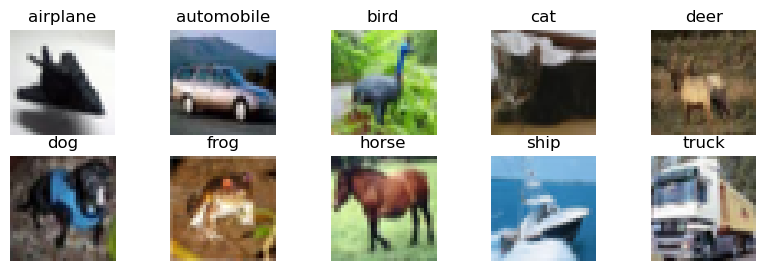

In [3]:
lab_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transforms.ToTensor())
utils.plot_one_instance_per_class(lab_dataset)

In [4]:
image_width = lab_dataset[0][0].shape[1]
print(f"The dataset is made of {image_width}x{image_width} pixels images.")

The dataset is made of 32x32 pixels images.


Here is a list of few transformations that can be applied to an image. 
These transformations require parameters such as : 

- $p$ : the probability of applying the transformation
- $size$ : the size of the cropped image
- and so on...

Feel free to modify these parameters to visualize their effects on the images using the *plot_before_after_augmentation* function.

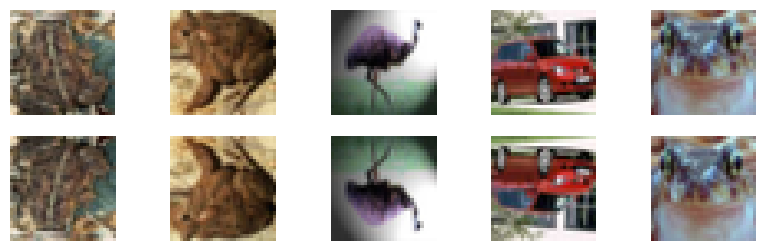

In [56]:
transformations = [
    transforms.CenterCrop(size=image_width/2),
    transforms.RandomCrop(size=image_width/2),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), shear=15),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomInvert(p=0.5),
    transforms.RandomSolarize(-0.1, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
]
my_transfo = transformations[4] # EDIT THIS LINE TO CHANGE THE TRANSFORMATION
utils.plot_before_after_augmentation(dataset=lab_dataset, transformation=my_transfo)

## Image classification

In this notebook, we will use a Wide Residual Network model.   

<div style="
    padding: 10px;
    border-radius: 10px;
    background-color: #cce5ff;
    border-left: 5px solid #004085;
    color: #004085;
">
<strong>Wide Residual Network</strong>  

Wide Residual Networks (WideResNet) are a variant of the standard ResNet architecture designed to improve accuracy and efficiency in image classification tasks. Unlike traditional ResNets, which increase depth to enhance performance, WideResNets instead expand the network’s width by using wider residual blocks with more channels. This design reduces the training time while maintaining high accuracy by improving gradient flow and representational capacity.</div>


The model that you will be using has been trained twice : 

- 1st training : on the IMAGENET dataset (the weights are provided by torch)
- 2nd training : on the CIFAR dataset (the author got the weights by training the torch model on the whole CIFAR dataset)

The model expects images to have a size of at least 224x224 because it was originally trained on the IMAGENET dataset.


The training that you will perform will use a subset of the whole CIFAR10 dataset in order for you not to wait for a while before getting results.

In [5]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    # transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=path_to_data, train=False, download=True, transform=transform)

# Generate a subset of the dataset containing only 2% of the data (1000 images)
train_subset, test_subset = utils.get_subset(trainset=trainset, testset=testset, percentage=0.02)

Files already downloaded and verified
Files already downloaded and verified
Training samples: 1000
Test samples: 200


### Training on the raw data

Let us train the model on the raw data for a few epochs for you to notice that it has already learnt most of the information present within the dataset. 

In [6]:
train_loader, val_loader = get_trainloader_valloader(dataset=train_subset, split=0.8, batch_size=32) # 80% train, 20% validation
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training set length : 800.
Validation set length : 200.


Let's evaluate the pretrained model on the testset.

In [ ]:
wrn = load_Wide_Residual_Network(device=device, path="./models/wrn_trained_on_raw_data/wrn_trained_on_raw_data")

utils.evaluate(wrn, test_loader, device)

Linear(in_features=2048, out_features=10, bias=True)


In [ ]:
criterion = nn.CrossEntropyLoss()
patience = 5
min_delta_loss = 0.001
min_delta_accuracy = 0.1

optimizer = optim.Adam(wrn.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# TRAINING
wrn_retrained = utils.train_WideResNet(model=wrn, trainloader=train_loader, valloader=val_loader, num_epochs=5,
                                     batch_size=32, optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                     patience=patience, min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

In [ ]:
utils.evaluate(wrn_retrained, test_loader, device)

Accuracy: 69.00%
Taux d'erreur: 31.00%


(0.69, 0.31000000000000005)

The model seems to have already learnt almost all the information present in the dataset.

The rest of the notebook consists in using augmentation startegies in order to improve the generalization of the model.

## About the importance of using good data augmentation policies

Before diving into the art of data augmentation, let us raise awareness on the potential issues triggered by bad augmentation policies.

All the augmentations that are considered in this notebook are **label-invariant**. It means that the label of the augmented data is the same as its raw version.

Unfortunately, when applying augmentations on a dataset, one might introduce bad-labelled data. The example below illustrates how unconvenient such unwanted augmentations can be.

Good data augmentation policies may be found empirically. However, such policies are not always transferable to other datasets. For example, horizontal flipping of images during training is an effective data augmentation method on CIFAR-10, but not on MNIST, due to the different symmetries present in these datasets.

<center><img src="https://github.com/fga-0/automating_data_augmentation/blob/main/img/bad_augmentation_mnist.jpg?raw=1" height="55%" width="55%"></img></center>

Augmented data may be obtained after applying several transformations to the data. This is called a composition of transformations. Heavy compositions might deteriorate the information and prevent a model from learning healthy information. Here is what it looks like to apply too many transformations to the data : 

<center><div style="text-align: center;">
    <img src="frog_0.gif" width="300" loop>
</div>

# Methods to automate data augmentation

Finding good augmentation strategies is a search problem.

All the transformations within a given search space do not allow a model to better its generalization. Worse, augmentations might even deteriorate the dataset as we have seen.

Besides, with composition, the search space grows quadratically so a brute-force search is not feasible.

In the field of automating data augmentation, algorithms may be classified in 3 categories according to the way transformations are selected within the search space : 

In what follows, 3 methods of automated data augmentation will be described :

- **RandAugment** : uses a random search
- **AutoAugment** : a method that uses reinforcement learning
- **Uncertainty-based sampling (UBS)** : a method that leverage the theoretical insights of data augmentation in a simplified linear setting

# RandAugment

The first algorithm with which we will experiment is named RandAugment. The idea is straightforward : in order to diversify the augmented data and benefit from different augmentation policies, RandAugment selects transformations ramdomly within the search space of transformations.

The *RA_augmentations.py* script contains all the transformations used by RandAugment if you want to take a look. The poor frog below undergoes all these transformations one by one  just for you to visualize concretely what kinds of transformations are available.


<center><div style="text-align: center;">
    <img src="frog.gif" width="300" loop>
</div>

RandAugment introduces a vastly simplified search space for data augmentation containing 2 interpretable hyperparameters : 

- **num_ops** : the number of transformations each image goes through
- **magnitude** : the intensity of the transformations applied to the images

<div class="alert alert-warning">
    
**Question**  
With $K$ being the number of available transformations and $N_{ops}$ the number of successive transformations to be applied to each image.
What is the dimension of the space of possible augmentations ?
</div>

<details class="alert alert-danger">
    <summary markdown="span"><b>Answer</b></summary>

$K^{N_{ops}}$
</details>

Let us load the CIFAR10 data and augment it using RandAugment implemented in *torch*.

In [ ]:
transform_randaugment = transforms.Compose([
    transforms.Resize(224),
    RandAugment(num_ops=2, magnitude=9),  # num_ops définit le nombre d'opérations aléatoires, magnitude leur intensité
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset_randaugment = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform_randaugment)

train_subset_RA, test_subset_RA = utils.get_subset(trainset=trainset_randaugment, testset=testset, percentage=0.02)

train_loader_RA, val_loader_RA = get_trainloader_valloader(dataset=train_subset_RA, split=0.8, batch_size=32)


Files already downloaded and verified


In [ ]:
wrn_RA = load_Wide_Residual_Network(device=device, path="./models/wrn_trained_on_raw_data/wrn_trained_on_raw_data")

optimizer = optim.Adam(wrn_RA.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# TRAINING on the augmented data
wrn_trained_RA = utils.train_WideResNet(model=wrn_RA, trainloader=train_loader_RA, valloader=val_loader_RA, num_epochs=5,
                                                       batch_size=32, optimizer=optimizer, criterion=criterion,
                                                       device=device, scheduler=scheduler, patience=patience,
                                                       min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

Epoch 1: Loss=1.9124, Accuracy=35.80%


Epoch 2: Loss=1.2958, Accuracy=62.70%


Epoch 3: Loss=1.0557, Accuracy=68.40%


Epoch 4: Loss=0.8857, Accuracy=73.50%


Epoch 5: Loss=0.7740, Accuracy=80.10%
Training complete!


In [ ]:
utils.evaluate(wrn_trained_RA, test_loader, device)

Accuracy: 73.00%
Taux d'erreur: 27.00%


(0.73, 0.27)

Hopefully the model has gained some performance in generalization thanks to the training on the augmented data.

# UTILE ?

In [ ]:
train_subset_raw_and_randaugment = ConcatDataset([train_subset, train_subset_randaugment])

In [ ]:
train_loader_raw_and_randaugment, val_loader_raw_and_randaugment = get_trainloader_valloader(dataset=train_subset_raw_and_randaugment,
                                                                                             split=0.8,
                                                                                             batch_size=32)
# test_loader_raw_and_randaugment = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# Load Wide ResNet model
# Load a pre-trained Wide ResNet-50-2 model:
wrn = wide_resnet50_2(pretrained=True)
# Freeze all model parameters except for the final layer:
for param in wrn.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = wrn.fc.in_features
# Replace the final classification layer to match your dataset:
wrn.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(wrn.fc)
# Move the model to the GPU for accelerated training:
wrn = wrn.to(device)

print(f"Using device: {device}")

In [ ]:
optimizer = optim.Adam(wrn.fc.parameters(), lr=0.001)
# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
wrn_trained_on_randaugment_data = utils.train_WideResNet(model=wrn, trainloader=train_loader_raw_and_randaugment, valloader=val_loader_raw_and_randaugment, num_epochs=5,
                                                         batch_size=32, optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                                         patience=patience, min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

In [ ]:
utils.evaluate(wrn_trained_on_randaugment_data, test_loader, device)

# AutoAugment

AutoAugment is an algorithm introduced by Google Brain that uses reinforcement learning to find the best augmentation policy for a given dataset.

## The search space

The goal of AutoAugment is to find the 5 best sub-policies for a given dataset.

A policy $S$ consists of many sub-policies $s_i$.

A given sub-policy consists of **two operations**, each operation being an image processing function such as translation, rotation, or shearing, and the probabilities and magnitudes with which the functions are applied.






In other words, for a given index $i$, the associated sub-policy $s_i$ is : 

$$s_i = (O_i^1, O_i^2)$$
$$O_i^k = (T_{i,k} , p_{i,k}, m_{i,k})$$
- $t_{i,k}$ : the $k^{th}$ transformation of the $i^{th}$ sub-policy
- p : the probability of applying $t_{i,k}$
- m : the magnitude of $t_{i,k}$

<div class="alert alert-success">

**Example of a sub-policy :** 

 (Rotate by 30° with 80% probability → Then apply Contrast adjustment with magnitude 6 and 70% probability)
 </div>

<div style="
    padding: 10px;
    border-radius: 10px;
    background-color: #cce5ff;
    border-left: 5px solid #004085;
    color: #004085;
">
<strong>Dimension of the search space</strong>  

In the original paper of AutoAugment, the magnitudes and probabilities are discretized in 10 and 11 values respectively.

With $N$ being the number of possible transformations, the dimension of the search space is $((N*10*11)^2)^5$.

For $N$ = 10, the search space has a dimension of ~$10^{30}$ !! 

This is way too high if we consider the computational cost of assessing the performance of each one of them. In the AutoAugment article, 15 000 sub-policies are considered (chosen randomly).

## The algorithm

The process of AutoAugment to find the best policy may be summarized as follows : 

<center><img src="https://github.com/fga-0/automating_data_augmentation/blob/main/img/AA_framework.png?raw=1" height="55%" width="55%"></img></center>

The **child network** is a neural network trained at each iteration on the augmented data generated thanks to the augmentation policy determined by the controller. 

The **controller** is a Recurrent Neural Network (an LSTM actually) that is updated at each iteration using policy gradient methods. The RNN tries to maximize the accuracy of the child model on the validation set.

<div class="alert alert-danger">

This RL-based policy search is **computationally expensive** but results in **high-quality augmentation strategies**.
</div>

## Transferability

The AutoAugment algorithm was trained on CIFAR-10, CIFAR-100, and ImageNet datasets.

After thousands of RL search iterations, AutoAugment found an optimal set of sub-policies that worked best for **CIFAR-10** and CIFAR-100.

These predefined augmentation policies are now available in *torchvision.transforms.AutoAugmentPolicy.CIFAR10*.

It allows us to use these augmentation strategies to enrich the CIFAR10 dataset.

In [ ]:
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

In [ ]:
transform_augment = transforms.Compose([
    transforms.Resize(224),
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset_aug = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform_augment)

Files already downloaded and verified


In [1]:
utils.plot_images(trainset_aug, 5)

NameError: name 'utils' is not defined

In [ ]:
train_subset_aug, test_subset_aug = utils.get_subset(trainset=trainset_aug, testset=testset, percentage=0.02)

train_loader_AA, val_loader_AA = get_trainloader_valloader(dataset=train_subset_aug, split=0.8, batch_size=32)

Training samples: 1000
Test samples: 200


Let us reload the model in order not to benefit from an artificial improvement due to the preceding training.

In [ ]:
wrn_AA = load_Wide_Residual_Network(device=device, path="./models/wrn_trained_on_raw_data/wrn_trained_on_raw_data")

NameError: name 'wide_resnet50_2' is not defined

In [ ]:
optimizer = optim.Adam(wrn_AA.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# TRAINING on the augmented data

wrn_trained_AA = utils.train_WideResNet(model=wrn_AA, trainloader=train_loader_AA, valloader=val_loader_AA, num_epochs=5,
                                                       batch_size=32, optimizer=optimizer, criterion=criterion,
                                                       device=device, scheduler=scheduler, patience=patience,
                                                       min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

Epoch 1: Loss=1.9124, Accuracy=35.80%


Epoch 2: Loss=1.2958, Accuracy=62.70%


Epoch 3: Loss=1.0557, Accuracy=68.40%


Epoch 4: Loss=0.8857, Accuracy=73.50%


Epoch 5: Loss=0.7740, Accuracy=80.10%
Training complete!


In [ ]:
utils.evaluate(wrn_trained_AA, test_loader, device)

Accuracy: 73.00%
Taux d'erreur: 27.00%


(0.73, 0.27)

# UTILE ??

Now let's concatenate the raw subset and the augmented subset in order to train the WideResNet with augmented data.

In [182]:
from torch.utils.data import ConcatDataset

In [ ]:
train_subset_raw_and_AA = ConcatDataset([train_subset, train_subset_aug])

train_loader_raw_and_AA, val_loader_raw_and_AA = get_trainloader_valloader(dataset=train_subset_raw_and_AA,
                                                                           split=0.8,
                                                                           batch_size=32)
# test_loader_raw_and_AA = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=2)

Let us reload the WideResNet pretrained network.

In [ ]:
# # Load a pre-trained Wide ResNet-50-2 model:
wrn = wide_resnet50_2(pretrained=True)
# Freeze all model parameters except for the final layer:
for param in wrn.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = wrn.fc.in_features
# Replace the final classification layer to match your dataset:
wrn.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(wrn.fc)
# Move the model to the GPU for accelerated training:
wrn = wrn.to(device)

Linear(in_features=2048, out_features=10, bias=True)


In [ ]:
optimizer = optim.Adam(wrn.fc.parameters(), lr=0.001)
# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
wrn_trained_on_raw_AND_augmented_data = utils.train_WideResNet(model=wrn, trainloader=train_loader_raw_and_AA, num_epochs=5, batch_size=32,
                                                               optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                                               valloader=val_loader_raw_and_AA, patience=patience,
                                                               min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

Epoch 1: Loss=1.7880, Accuracy=40.40%


Epoch 2: Loss=1.2292, Accuracy=61.40%


Epoch 3: Loss=1.1016, Accuracy=63.40%


Epoch 4: Loss=0.9978, Accuracy=69.30%


Epoch 5: Loss=0.9154, Accuracy=71.45%
Training complete!


In [ ]:
utils.evaluate(wrn_trained_on_raw_AND_augmented_data, test_loader, device)

Accuracy: 75.50%
Taux d'erreur: 24.50%


(0.755, 0.245)

# Data Augmentation Under A Simplified Linear Setting

Sen Wu et al. developped a theoretical framework in order to understand data augmentation better.

This theoretical chapter will eventually lead you to another algorithm that stands as a well-balanced trade-off between heavy Reinforcement Learning and RandAugment methods.

## Problem formulation

### Setting

Let us consider an over-parametrized linear regression : the number of parameters is greater than the number of training samples.

$$X = [x_1\in\mathbb{R^p}, x_2\in\mathbb{R^p}, ..., x_n\in\mathbb{R^p}]$$
$$Y = X\beta + \epsilon$$
$$p > n$$

Let us recall the Ridge estimator using an $l_2$ regularization with parameter $\lambda$ :

$$L(\hat{\beta}) = \left \lVert X\hat{\beta}-Y \right \rVert_2^2 + \lambda * \left \lVert \hat{\beta} \right \rVert_2^2

**How does adding transformed samples impact the ridge estimator's generalization error ?**

In order to answer to this question, we will compare the Ridge estimator to the augmented Ridge estimator 
$$\hat\beta_{aug} = \hat\beta (X_{aug}, Y_{aug})$$

We will consider 3 categories of transformations which are :

1. **label-invariant** transformations
2. **label-mixing** transformations
3. **composition** of transformations

### Label-invariant transformations

As the name suggests, these transformations do not alter the label of the original data. All the transformations studied until now were label-invariant.

Let us denote : 
- a transformation 
$$F \in \mathbb{R^{d\times d}}$$
- a training sample
$$(x, y)$$
- the transformed sample 
$$(Fx, y)$$

In this context, adding, the transformed sample reduces the estimation error of the ridge estimator : 
$$e(\hat\beta) - e(\hat\beta_{aug}) \geq \frac{\beta^\intercal P^{\perp}_X Fx}{n}$$
$P^{\perp}_X$ denotes the projection to the orthogonal subspace of $X$.

➡️The transformed sample adds a new direction outside the span of the training data, which does not cover the entire space because $n < p$

### Composition of transformations

A composition of transformations is the application of several transformations successively to the same data sample.

Let us denote : 
- two transformations : 
$$F_1 \in \mathbb{R^{d\times d}}, F_2 \in \mathbb{R^{d\times d}}$$
- a training sample
$$(x, y)$$
- the transformed sample 
$$(F_1 F_2 x, y)$$

The estimation error is once again reduced if the augmented data is added to the original dataset : 
$$e(\hat\beta) - e(\hat\beta_{aug}) \geq \frac{(\beta^\intercal P^{\perp}_X F_1 F_2x)^2}{n}$$
This result is very close to the preceding one.

### Label-mixing transformations

These transformation are quite particular as the label of the augmented sample is a mix of the labels of the samples that were used for the augmentation.

Let us denote : 
- a mixing parameter : 
$$\alpha$$
- two training samples
$$(x_1, y_1), (x_2, y_2)$$
- the transformed sample 
$$(\alpha x_1 + (1-\alpha x_2), \alpha y_1 + (1-\alpha y_2))$$

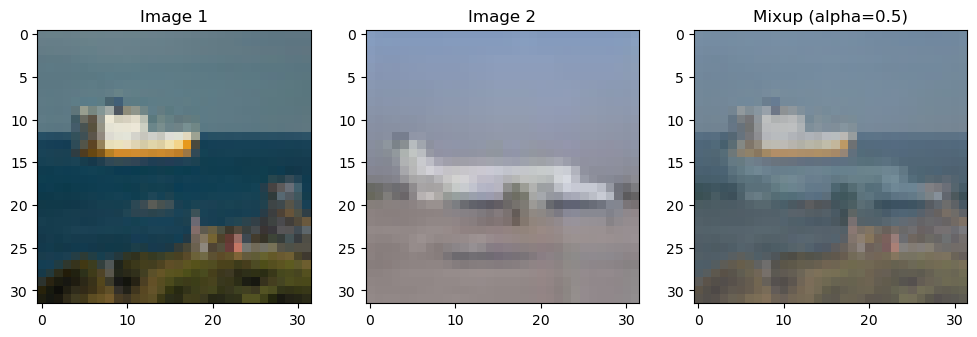

In [27]:
image1 = lab_dataset[np.random.randint(0, len(lab_dataset))][0]
image2 = lab_dataset[np.random.randint(0, len(lab_dataset))][0]
utils.demo_mixup(image1=image1, image2=image2, alpha=0.5) # Change alpha to see different results

In this context, adding the mixup samples $x_{aug} = \alpha x_1 + (1 - \alpha) x_2$ reduces estimation error :
$$e(\hat\beta) - e(\hat\beta_{aug}) \geq \frac{\lambda^2 \left \lVert X\beta \right \rVert^2}{n^2}$$
💡This result might be more comprehensive looking at the expectation of the covariance of a randomly selected sample : 
$$\mathbb{E} \left[ x^{aug} x^{aug^T} \right] = (1 - 2\alpha)^2 \frac{X^T X}{n}$$
$$\Rightarrow \mathbb{E} \left[ \frac{X^T X + x^{aug} x^{aug^T}}{n+1} \right] = \left( \frac{n}{n+1} + \frac{(1-2\alpha)^2}{(n+1)} \right) \frac{X^T X}{n} = \gamma \frac{X^T X}{n}$$
And $\gamma$ is less than 1. 

➡️ So the sample covariance of the augmented dataset is smaller than the original sample covariance.


# Uncertainty-based sampling of transformations

The Uncertainty-based sampling of transformations is an augmentation scheme that relies on the preceding results. 

The scheme is adapted to identify whether or not adding new data is beneficial to improve the generalization.

The idea is that for a batch of $B$ samples, $C$ transformations are to be applied to each sample. The transformations are randomly sampled among the transformation functions provided by the user.

Using the current parameters of the model, the losses associated to each augmented sample are evaluated and for each sample, the $S$ augmented versions with the highest losses are kept.

<center><img src="https://github.com/fga-0/automating_data_augmentation/blob/main/img/UBS_schema0.png?raw=1" height="55%" width="55%"></img></center>

In the end, $S\times B$ augmented samples are obtained and used to update the parameters of the model using back propagation.

<center><img src="https://github.com/fga-0/automating_data_augmentation/blob/main/img/ubs_algorithm.png?raw=1" height="55%" width="55%"></img></center>

In [7]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

trainset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=path_to_data, train=False, download=True, transform=transform)

train_subset_UBS, test_subset_UBS = utils.get_subset(trainset=trainset, testset=testset, percentage=0.02)

image_width = trainset[0][0].shape[1]

F_transformations = [
    transforms.CenterCrop(size=image_width/2),
    transforms.RandomCrop(size=image_width/2),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), shear=15),
    # transforms.GaussianBlur(kernel_size=3),
    transforms.RandomInvert(p=0.5),
    # transforms.RandomSolarize(-0.1, p=0.5),
    # transforms.RandomAutocontrast(p=0.5),
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
]

Files already downloaded and verified
Files already downloaded and verified
Training samples: 1000
Test samples: 200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.535425..3.117904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..1.5707283].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5707283..2.913165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7870152..1.9602616].


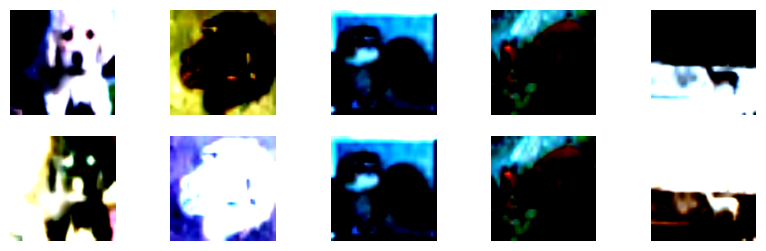

In [8]:
utils.plot_before_after_augmentation(dataset=train_subset_UBS, transformation=F_transformations[6])

In [9]:
wrn_UBS = load_Wide_Residual_Network(device=device, path="./models/wrn_trained_on_raw_data/wrn_trained_on_raw_data")

Linear(in_features=2048, out_features=10, bias=True)


In [155]:
utils.evaluate(wrn_UBS, test_loader, device)

Accuracy: 81.00%
Taux d'erreur: 19.00%


(0.81, 0.18999999999999995)

In [10]:
train_loader_UBS = DataLoader(train_subset_UBS, batch_size=32, shuffle=False)

In [ ]:
G_default_transformations = transforms.Compose([
    transforms.Resize(224),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

In [12]:
importlib.reload(generalization_effects)
import generalization_effects
from generalization_effects import uncertainty_based_sampling

In [14]:
loss_function = nn.CrossEntropyLoss()

trainset_UBS = uncertainty_based_sampling(
    batch=train_subset_UBS,
    F_transformations=F_transformations,
    G_default_transformations=G_default_transformations,
    model=wrn_UBS,
    loss_function=loss_function,
    L=2, # the number of composition steps
    C=10, # number of augmented data per input data
    S=1, # number of selected data points used for training
    device=device
    )

KeyboardInterrupt: 

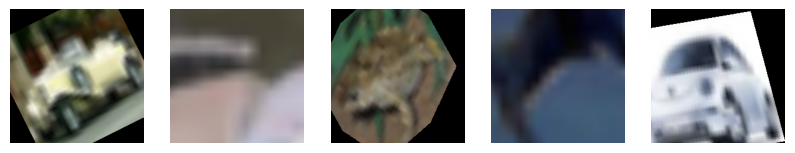

In [196]:
utils.plot_images(dataset=trainset_UBS, n_images=5)

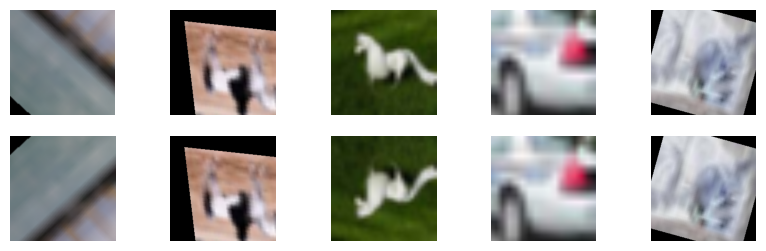

In [162]:
utils.plot_before_after_augmentation(dataset=trainset_UBS, transformation=transformations[4])

In [163]:
train_loader_UBS, val_loader_UBS = get_trainloader_valloader(dataset=trainset_UBS,
                                                           split=0.8,
                                                           batch_size=32)

Training set length : 800.
Validation set length : 200.


In [ ]:
optimizer = optim.Adam(wrn_UBS.fc.parameters(), lr=0.0000001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = nn.CrossEntropyLoss()

In [176]:
patience = 5
min_delta_loss = 0.001
min_delta_accuracy = 0.1

Epoch 1: Loss=2.2440, Accuracy=34.00%, Val Loss=2.5929, Val Accuracy=28.00%
Epoch 1: Loss=2.2440, Accuracy=34.00%


Epoch 2: Loss=2.2803, Accuracy=33.12%, Val Loss=2.0879, Val Accuracy=36.50%
Epoch 2: Loss=2.2803, Accuracy=33.12%


Epoch 3: Loss=2.2529, Accuracy=33.88%, Val Loss=2.2331, Val Accuracy=39.50%
Epoch 3: Loss=2.2529, Accuracy=33.88%


Epoch 4: Loss=2.1697, Accuracy=34.75%, Val Loss=2.1621, Val Accuracy=36.50%
Epoch 4: Loss=2.1697, Accuracy=34.75%


Epoch 5: Loss=2.2582, Accuracy=32.38%, Val Loss=2.0987, Val Accuracy=36.50%
Epoch 5: Loss=2.2582, Accuracy=32.38%
Training complete!


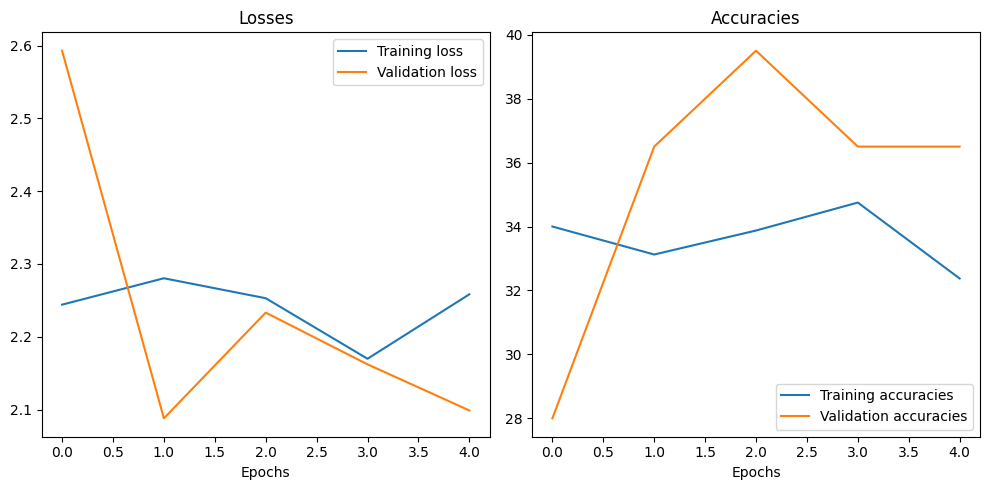

In [177]:
wrn_trained_UBS = utils.train_WideResNet(model=wrn_UBS, trainloader=train_loader_UBS, patience=patience,
                                         valloader=val_loader_UBS, num_epochs=5, batch_size=32,
                                         optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                         min_delta_accuracy=min_delta_accuracy, min_delta_loss=min_delta_loss)

In [167]:
utils.evaluate(wrn_trained_UBS, test_loader, device)

Accuracy: 8.50%
Taux d'erreur: 91.50%


(0.085, 0.915)

## Concat

Let us try to concatenate the augmented images with the original dataset in order to avoid catastrophic forgetting.

In [183]:
trainset_UBS_concat = ConcatDataset([train_subset, trainset_UBS])

train_loader_UBS_concat, val_loader_UBS_concat = get_trainloader_valloader(dataset=trainset_UBS_concat,
                                                                           split=0.8,
                                                                           batch_size=32)

Training set length : 1600.
Validation set length : 400.


In [190]:
wrn_UBS = wide_resnet50_2()
# Freeze all model parameters except for the final layer:
for param in wrn_UBS.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = wrn_UBS.fc.in_features
# Replace the final classification layer to match your dataset:
wrn_UBS.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(wrn_UBS.fc)
# Move the model to the GPU for accelerated training:
wrn_UBS = wrn_UBS.to(device)
wrn_UBS.load_state_dict(torch.load("./wrn_trained_on_raw_data", weights_only=False, map_location=torch.device('cpu')))

Linear(in_features=2048, out_features=10, bias=True)


<All keys matched successfully>

In [191]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(wrn_UBS.fc.parameters(), lr=0.000000001)
# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = nn.CrossEntropyLoss()

In [192]:
patience = 5
min_delta_loss = 0.001
min_delta_accuracy = 0.1

Epoch 1: Loss=1.5116, Accuracy=54.75%, Val Loss=1.6820, Val Accuracy=53.75%
Epoch 1: Loss=1.5116, Accuracy=54.75%


Epoch 2: Loss=1.5162, Accuracy=54.00%, Val Loss=1.6640, Val Accuracy=55.75%
Epoch 2: Loss=1.5162, Accuracy=54.00%


Epoch 3: Loss=1.5295, Accuracy=55.81%, Val Loss=1.6088, Val Accuracy=56.75%
Epoch 3: Loss=1.5295, Accuracy=55.81%


Epoch 4: Loss=1.5082, Accuracy=55.44%, Val Loss=1.7046, Val Accuracy=55.75%
Epoch 4: Loss=1.5082, Accuracy=55.44%


Epoch 5: Loss=1.5559, Accuracy=54.75%, Val Loss=1.6455, Val Accuracy=56.00%
Epoch 5: Loss=1.5559, Accuracy=54.75%
Training complete!


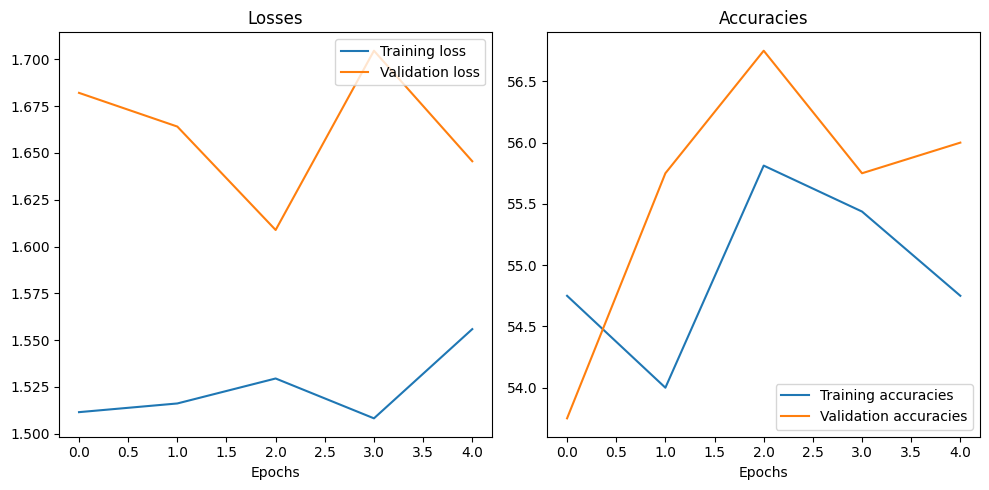

In [193]:
wrn_trained_UBS_concat = utils.train_WideResNet(model=wrn_UBS, trainloader=train_loader_UBS_concat, patience=patience,
                                         valloader=val_loader_UBS_concat, num_epochs=5, batch_size=32,
                                         optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                         min_delta_accuracy=min_delta_accuracy, min_delta_loss=min_delta_loss)

In [194]:
utils.evaluate(wrn_trained_UBS_concat, test_loader, device)

Accuracy: 10.50%
Taux d'erreur: 89.50%


(0.105, 0.895)

# Other automated augmentation techniques

In this notebook, we went through three methods for automating data augmentation:  
- **RandAugment**  
- **AutoAugment**  
- **Uncertainty-Based Sampling**  

However, there are many other methods that can further enhance model performance. Techniques like **Mixup, CutMix, and AugMix** introduce novel ways of augmenting data by mixing samples or enforcing consistency across transformations. Additionally, **learned augmentation policies** and **generative approaches** (such as adversarial augmentation with GANs) continue to push the boundaries of automated augmentation.  

Choosing the right augmentation strategy depends on the dataset, model, and task at hand. Experimentation and adaptation remain crucial for finding the most effective approach to improving generalization and robustness.


# Bibliography

**Uncertainty based sampling**
    https://arxiv.org/abs/2005.00695

**RandAugment**
    https://arxiv.org/abs/1909.13719

**AutoAugment**
    https://arxiv.org/abs/1805.09501
    
**The Stanford AI lab**
    https://ai.stanford.edu/blog/data-augmentation/

